In [1]:
import os, io, copy
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
IMG_SHAPE = (224, 224, 3)
IMG_SIZE = IMG_SHAPE[:-1]

TEST_SIZE = 0.1
VAL_SIZE = 0.1

MAX_FAR = 1e-3

BASE_PATH = 'C:/Users/ngwei/Desktop/ITI110 Deep Learning Project'
DATASET_PATH = os.path.join(BASE_PATH, 'data', 'main')

In [3]:
def load_data(path=DATASET_PATH, test_size=TEST_SIZE, val_size=VAL_SIZE):
    
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    folders = glob(path+'/*')
    
    # to ensure similar distribution of number of images per class
    def get_folder_size_bins(folders):
        folders_size = [len(os.listdir(folder)) for folder in folders]
        qcut_list = list(pd.qcut(folders_size, 10, duplicates='drop'))
        return qcut_list
    
    qualified_folders = [folder for folder in folders if len(os.listdir(folder)) >= 2]
    folders_size_bins = get_folder_size_bins(qualified_folders)
    train_folders, test_folders = train_test_split(qualified_folders, stratify=folders_size_bins,
                                                   test_size=test_size, random_state=1234)
    
    folders_size_bins = get_folder_size_bins(train_folders)
    train_folders, val_folders = train_test_split(train_folders, stratify=folders_size_bins,
                                                  test_size=val_size, random_state=1234)
    
    label, lbl2name = 0, dict()
    for folder in train_folders:
        files = glob(folder+'/*')
        X_train.extend(files)
        y_train.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in val_folders:
        files = glob(folder+'/*')
        X_val.extend(files)
        y_val.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in test_folders:
        files = glob(folder+'/*')
        X_test.extend(files)
        y_test.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    print('Train:')
    print('\t Number of Classes:', len(train_folders))
    print('\t Number of Images: ', len(y_train), '\n')
    print('Val:')
    print('\t Number of Classes:', len(val_folders))
    print('\t Number of Images: ', len(y_val), '\n')
    print('Test:')
    print('\t Number of Classes:', len(test_folders))
    print('\t Number of Images: ', len(y_test), '\n')
    print('-'*50)
    print('Total:')
    print('\t Number of Classes:', len(train_folders)+len(val_folders)+len(test_folders))
    print('\t Number of Images: ', len(y_train)+len(y_val)+len(y_test))
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), lbl2name


(X_train_paths, y_train_labels), (X_val_paths, y_val_labels), (X_test_paths, y_test_labels), lbl2name = load_data()

Train:
	 Number of Classes: 1436
	 Number of Images:  21135 

Val:
	 Number of Classes: 160
	 Number of Images:  2759 

Test:
	 Number of Classes: 178
	 Number of Images:  2742 

--------------------------------------------------
Total:
	 Number of Classes: 1774
	 Number of Images:  26636


In [4]:
def image_preprocessing(path):
    image = Image.open(path).resize(IMG_SIZE)
    image = np.asarray(image).astype("float32")
    image = preprocess_input(image, data_format='channels_last')
    return image

def get_images_from_paths(img_paths, image_preprocessing_fn=image_preprocessing):
    images = [image_preprocessing_fn(path) for path in img_paths]
    return np.array(images, dtype='float32')

def image_facenet_preprocessing(path):
    image = Image.open(path).resize((160, 160))
    image = np.asarray(image).astype("float32")
    image = (image * 2/255) - 1
    return image

def get_embedding_from_paths(img_paths):
    embeddings = [np.load(f'{path[:61]}_emb{path[61:-4]}.npy') for path in img_paths]
    return np.array(embeddings, dtype='float32')

In [5]:
def build_EfficientFaceNet(pretrained_path=''):
    
    Inp = tf.keras.layers.Input(IMG_SHAPE, name='input')
    base_model = EfficientNetB0(include_top=False, input_tensor=Inp, drop_connect_rate=0.5)
    
    x = base_model.output
    x = tf.keras.layers.Dropout(0.5, name='dropout1')(x)
    x = tf.keras.layers.DepthwiseConv2D((7,7), name='glb_depth_conv')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout2')(x)
    x = tf.keras.layers.Dense(128, name='non_norm_emb')(x)
    Out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='norm_emb')(x)
    
    EfficientFaceNet = tf.keras.models.Model(inputs=Inp,
                                             outputs=Out,
                                             name='EfficientFaceNet')
    if pretrained_path:
        EfficientFaceNet.load_weights(pretrained_path)
        
    return EfficientFaceNet

In [6]:
def build_SimNet():
    
    Inp_webcam = tf.keras.layers.Input(128, name='input_webcam')
    Inp_db = tf.keras.layers.Input(128, name='input_db')
    
    sq_diff_trf = tf.keras.layers.Lambda(lambda x: (x[0]-x[1])**2, name='sq_diff')([Inp_webcam, Inp_db])
    sq_diff_trf = tf.keras.layers.Dropout(0.5, name='dropout_sq_diff_trf')(sq_diff_trf)
    sq_diff_trf = tf.keras.layers.Dense(64, name='dense_sq_diff_trf')(sq_diff_trf)
    
    mul_trf = tf.keras.layers.Multiply(name='mul')([Inp_webcam, Inp_db])
    mul_trf = tf.keras.layers.Dropout(0.5, name='dropout_mul_trf')(mul_trf)
    mul_trf = tf.keras.layers.Dense(64, name='dense_mul_trf')(mul_trf)
    
    x = tf.keras.layers.Concatenate(name='concat')([sq_diff_trf, mul_trf])
    x = tf.keras.layers.Dropout(0.5, name='dropout1')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_concat')(x)
    x = tf.keras.layers.Dropout(0.1, name='dropout2')(x)
    Out = tf.keras.layers.Dense(1, activation='sigmoid', name='sim_prob')(x)
    
    SimNet = tf.keras.models.Model(inputs=[Inp_webcam, Inp_db], outputs=Out, name='SimNet')
    
    return SimNet

In [7]:
def get_report(model, image_preprocessing_fn, paths, labels, threshold=None):
    
    if image_preprocessing_fn:
        images = get_images_from_paths(paths, image_preprocessing_fn=image_preprocessing_fn)
        embeddings = model.predict(images, batch_size=512)
    else:
        embeddings = get_embedding_from_paths(paths)
    embeddings = tf.math.l2_normalize(embeddings, axis=1)
        
    actual_similarities, predicted_similarities = [], []

    for i, (registered_embedding, registered_label) in enumerate(zip(embeddings, labels)):
        registered_embedding = np.array(registered_embedding)
        webcam_embeddings = np.delete(embeddings, i, axis=0)
        webcam_labels = np.delete(labels, i, axis=0)

        if image_preprocessing_fn:
            curr_pred_similarities = np.matmul(webcam_embeddings, np.transpose(registered_embedding))
        else:
            curr_pred_similarities = model([
                np.array(webcam_embeddings),
                np.array([registered_embedding for _ in range(len(webcam_embeddings))])
            ])
            curr_pred_similarities = np.array(curr_pred_similarities).flatten()

        predicted_similarities.extend(curr_pred_similarities)

        curr_actual_similarities = (webcam_labels==registered_label).astype(int)
        actual_similarities.extend(curr_actual_similarities)    
    
    if threshold:
        predicted_authorisations = ['Allow' if similarity >= threshold else 'Deny' for similarity in predicted_similarities]
        actual_authorisations = ['Allow' if similarity == 1 else 'Deny' for similarity in actual_similarities]
        print(classification_report(actual_authorisations, predicted_authorisations, digits=4))
        return actual_authorisations, predicted_authorisations
    
    return actual_similarities, predicted_similarities

In [8]:
def get_best_threshold_by_fixed_fpr(y, scores, max_fpr):
    fpr, tpr, thresholds = roc_curve(y, scores)
    best_threshold = thresholds[np.argmax(tpr[fpr<max_fpr])]
    print(f'Best Threshold: {best_threshold:.4f}')
    return best_threshold

# Sumary

In [9]:
distilEfficientFaceNet = build_EfficientFaceNet(
    os.path.join(BASE_PATH, 'models', 'distilEfficientFaceNet - run6', 'savedweights_distilEfficientFaceNet - run6')
)
distilEfficientFaceNet_actual_similarities, distilEfficientFaceNet_predicted_similarities = get_report(
    distilEfficientFaceNet, image_preprocessing, X_test_paths, y_test_labels
)

siameseEfficientFaceNet = build_EfficientFaceNet(
    os.path.join(BASE_PATH, 'models', 'siameseEfficientFaceNet - run18', 'savedweights_siameseEfficientFaceNet - run18')
)
siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities = get_report(
    siameseEfficientFaceNet, image_preprocessing, X_test_paths, y_test_labels
)

SimNet = build_SimNet()
SimNet.load_weights(
    os.path.join(BASE_PATH, 'models', 'simEfficientFaceNet - run2', 'savedweights_simEfficientFaceNet - run2')
)
SimNet_actual_similarities, SimNet_predicted_similarities = get_report(
    SimNet, None, X_test_paths, y_test_labels
)

FaceNet = tf.keras.models.load_model(os.path.join(BASE_PATH, 'models', 'FaceNet', 'facenet_model'))
FaceNet_actual_similarities, FaceNet_predicted_similarities = get_report(
    FaceNet, image_facenet_preprocessing, X_test_paths, y_test_labels
)

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\keras\layers\core.py:1043: UserWarning: keras.layers.core.lambda_layer is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


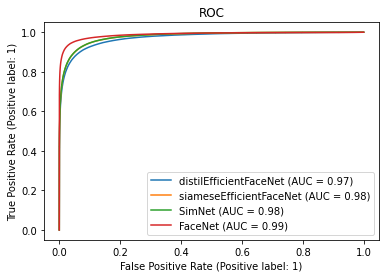

In [10]:
disp = RocCurveDisplay.from_predictions(
    distilEfficientFaceNet_actual_similarities, distilEfficientFaceNet_predicted_similarities,
    name='distilEfficientFaceNet'
)
RocCurveDisplay.from_predictions(
    siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities,
    name='siameseEfficientFaceNet', ax=disp.ax_
)
RocCurveDisplay.from_predictions(
    SimNet_actual_similarities, SimNet_predicted_similarities,
    name='SimNet', ax=disp.ax_
)
RocCurveDisplay.from_predictions(
    FaceNet_actual_similarities, FaceNet_predicted_similarities,
    name='FaceNet', ax=disp.ax_
)
plt.title("ROC")
plt.show()

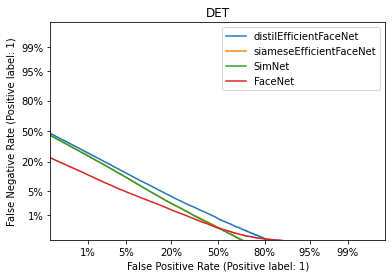

In [11]:
disp = DetCurveDisplay.from_predictions(
    distilEfficientFaceNet_actual_similarities, distilEfficientFaceNet_predicted_similarities,
    name='distilEfficientFaceNet'
)
DetCurveDisplay.from_predictions(
    siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities,
    name='siameseEfficientFaceNet', ax=disp.ax_
)
DetCurveDisplay.from_predictions(
    SimNet_actual_similarities, SimNet_predicted_similarities,
    name='SimNet', ax=disp.ax_
)
DetCurveDisplay.from_predictions(
    FaceNet_actual_similarities, FaceNet_predicted_similarities,
    name='FaceNet', ax=disp.ax_
)
plt.title("DET")
plt.legend(loc='upper right')
plt.show()

# distilEfficientFaceNet

In [12]:
best_distilEfficientFaceNet_threshold = get_best_threshold_by_fixed_fpr(
    distilEfficientFaceNet_actual_similarities, distilEfficientFaceNet_predicted_similarities, MAX_FAR
)

Best Threshold: 0.5350


In [13]:
distilEfficientFaceNet_actual_authorisations, distilEfficientFaceNet_predicted_authorisations = get_report(
    distilEfficientFaceNet, image_preprocessing,
    X_test_paths, y_test_labels,
    threshold = best_distilEfficientFaceNet_threshold
)

              precision    recall  f1-score   support

       Allow     0.9585    0.4976    0.6551    333162
        Deny     0.9772    0.9990    0.9880   7182660

    accuracy                         0.9768   7515822
   macro avg     0.9678    0.7483    0.8216   7515822
weighted avg     0.9764    0.9768    0.9732   7515822



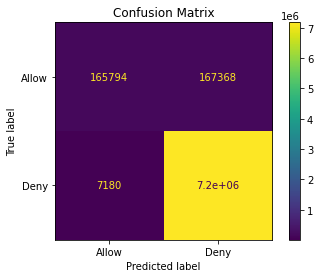

In [14]:
ConfusionMatrixDisplay.from_predictions(
    distilEfficientFaceNet_actual_authorisations, distilEfficientFaceNet_predicted_authorisations
)
plt.title("Confusion Matrix")
plt.show()

# siameseEfficientFaceNet

In [15]:
best_siameseEfficientFaceNet_threshold = get_best_threshold_by_fixed_fpr(
    siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities, MAX_FAR
)

Best Threshold: 0.5443


In [16]:
siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities = get_report(
    siameseEfficientFaceNet, image_preprocessing,
    X_test_paths, y_test_labels,
    threshold = best_siameseEfficientFaceNet_threshold
)

              precision    recall  f1-score   support

       Allow     0.9601    0.5180    0.6729    333162
        Deny     0.9781    0.9990    0.9884   7182660

    accuracy                         0.9777   7515822
   macro avg     0.9691    0.7585    0.8307   7515822
weighted avg     0.9773    0.9777    0.9745   7515822



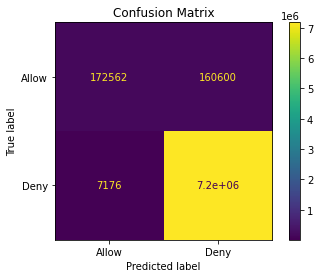

In [17]:
ConfusionMatrixDisplay.from_predictions(
    siameseEfficientFaceNet_actual_similarities, siameseEfficientFaceNet_predicted_similarities
)
plt.title("Confusion Matrix")
plt.show()

# SimNet

In [12]:
best_SimNet_threshold = get_best_threshold_by_fixed_fpr(
    SimNet_actual_similarities, SimNet_predicted_similarities, MAX_FAR
)

Best Threshold: 0.9485


In [13]:
SimNet_actual_similarities, SimNet_predicted_similarities = get_report(
    SimNet, None,
    X_test_paths, y_test_labels,
    threshold = best_SimNet_threshold
)

              precision    recall  f1-score   support

       Allow     0.9601    0.5186    0.6734    333162
        Deny     0.9781    0.9990    0.9885   7182660

    accuracy                         0.9777   7515822
   macro avg     0.9691    0.7588    0.8309   7515822
weighted avg     0.9773    0.9777    0.9745   7515822



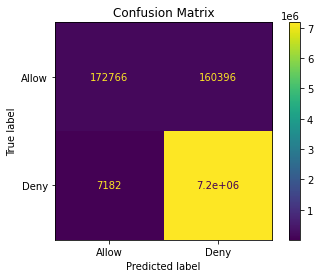

In [14]:
ConfusionMatrixDisplay.from_predictions(
    SimNet_actual_similarities, SimNet_predicted_similarities
)
plt.title("Confusion Matrix")
plt.show()

# FaceNet

In [21]:
best_FaceNet_threshold = get_best_threshold_by_fixed_fpr(
    FaceNet_actual_similarities, FaceNet_predicted_similarities, MAX_FAR
)

Best Threshold: 0.4943


In [22]:
FaceNet_actual_similarities, FaceNet_predicted_similarities = get_report(
    FaceNet, image_facenet_preprocessing,
    X_test_paths, y_test_labels,
    threshold = best_FaceNet_threshold
)

              precision    recall  f1-score   support

       Allow     0.9720    0.7493    0.8462    333162
        Deny     0.9885    0.9990    0.9937   7182660

    accuracy                         0.9879   7515822
   macro avg     0.9803    0.8741    0.9200   7515822
weighted avg     0.9878    0.9879    0.9872   7515822



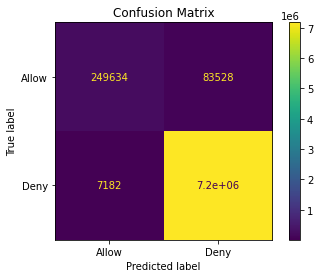

In [23]:
ConfusionMatrixDisplay.from_predictions(
    FaceNet_actual_similarities, FaceNet_predicted_similarities
)
plt.title("Confusion Matrix")
plt.show()